In [1]:
import argparse
import time

import torch
from PIL import Image
from torch.autograd import Variable
from torchvision.transforms import ToTensor, ToPILImage

from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt

import models as models
import data_utils as dutils

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/hg/by60chbx3gv__xtd5c1p9sxm0000gn/T/ipykernel_3566/1655723697.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
UPSCALE_FACTOR = 2
TEST_MODE = False
IMAGE_NAME = '/Volumes/DataDrive/clim_tif/additional_train/2016-12-05.tif'
MODEL_NAME = '/Volumes/DataDrive/clim_model_runs/epochs/netG_run_11_epoch_25.pth'

In [3]:
# downscale the test image
hr_image = Image.open(IMAGE_NAME)
high_res = np.array(hr_image)

# get the input LR image from output HR image by blurring, cropping, then interpolating
h1,w1 = high_res.shape
blurred = np.zeros_like(high_res)
blurred = gaussian_filter(high_res, sigma = (0.55, 0.55))
half_res = blurred[::2, ::2]

# Code involved in interpolating the blurred image back up to high res resolution
h2,w2 = half_res.shape
x = np.arange(h2)
y = np.arange(w2)
xnew = np.arange(0, h2, h2/h1)
ynew = np.arange(0, w2, w2/w1)
low_res = np.zeros_like(high_res)
f = RectBivariateSpline(x, y, half_res[:, :])
low_res[:, :] = f(xnew, ynew)

Text(0.5, 1.0, 'Low Res Image')

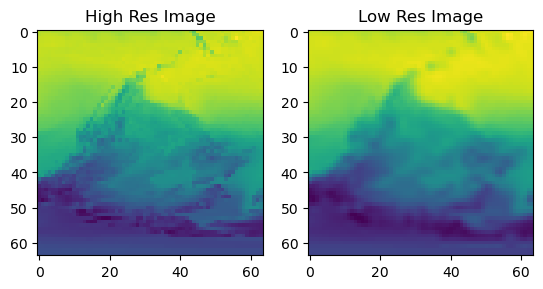

In [4]:
plt.subplot(121)
plt.imshow(high_res)
plt.title('High Res Image')
plt.subplot(122)
plt.imshow(low_res)
plt.title('Low Res Image')
#plt.savefig('/Users/ryaneagan/Desktop/test_output.png')

torch.Size([1, 64, 64])
(1, 64, 64)


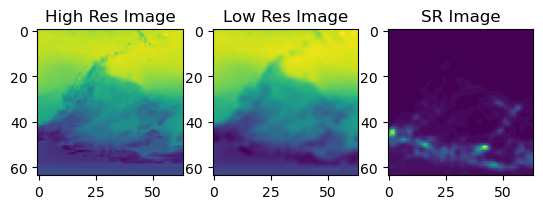

In [6]:

model = models.Generator(1,UPSCALE_FACTOR).eval()

model.load_state_dict(torch.load(MODEL_NAME), strict=False)

image = torch.nan_to_num(torch.from_numpy(low_res).float()).unsqueeze(0)
#image = image[None,:,:,:]
out = model(image)
print(out.shape)
out_np = out.detach().numpy()
print(out_np.shape)
out_image = ToPILImage()(out[0].data.cpu())
#out_image.save('out_srf_' + str(UPSCALE_FACTOR) + '_' + IMAGE_NAME)

plt.subplot(131)
plt.imshow(high_res)
plt.title('High Res Image')
plt.subplot(132)
plt.imshow(low_res)
plt.title('Low Res Image')
plt.subplot(133)
plt.imshow(out_np[0,:,:])
plt.title('SR Image')
plt.savefig('/Users/ryaneagan/Desktop/test_output.png')

In [141]:
out_np

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]]], dtype=float32)